#### !pip install prophet

# Imports

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import (
    mean_absolute_error, mean_absolute_percentage_error,
    root_mean_squared_error
)

%matplotlib inline

In [19]:
air_data = pd.read_csv('/Users/asliozdemirstrollo/Documents/Documents/Time Series/Clean Skies London/air-quality-london-monthly-averages.csv')


# Limiting to desired information
target: str = 'London Mean Roadside:Nitrogen Dioxide (ug/m3)'
air_data: pd.DataFrame = air_data[['Month', target]]

In [20]:
air_data.shape

(139, 2)

# Cleaning

In [21]:
# Converting to datetime, using format to interpret format
air_data['Month'] = pd.to_datetime(air_data['Month'], format='%b-%y')

# Can't have duplicate dates, aggregating all rows with the same date
no2_df: pd.DataFrame = (
    air_data
    .resample('MS', on='Month') # Aggregating daily
    .agg(y=(target, 'mean')) # Getting the average no2 and naming it y for prophet
    .reset_index() # Making Month a column again after the agg
    .rename(columns={'Month':'ds'}) # Renaming to prophet format
)
no2_df

,ds,y
0,2008-01-01,55.5
1,2008-02-01,75.9
2,2008-03-01,55.6
3,2008-04-01,61.8
4,2008-05-01,62.9
...,...,...
135,2019-04-01,46.2
136,2019-05-01,39.7
137,2019-06-01,34.9
138,2019-07-01,NaN


We could interpolate missing values, but it's generally safer to let Prophet simply ignore them. 

In [22]:
no2_df.dropna(inplace=True)

# Train Test Split

Determining split index by desired training data proportion

In [23]:
# Calculating split location
total_months = len(no2_df)
train_size = 0.9
idx_split = int(total_months * train_size)

# Separating training months from testing months
train_df: pd.DataFrame = no2_df.iloc[:idx_split]
test_df: pd.DataFrame = no2_df.iloc[idx_split:]

# Modeling

In [24]:
# Setting up scoring

def score_model(
    y_true : pd.Series, 
    y_pred : pd.Series,
) -> dict[str, float]:
    "Compute various scores and return dict"
    
    scores = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred)
    }
    return scores

# Setting up scoreboard
scoreboard = pd.DataFrame(columns=['Model', 'MAE', 'MAPE', 'RMSE']).set_index('Model')

In [25]:
# Fitting model to training data
model = Prophet()
model.fit(train_df)

09:23:03 - cmdstanpy - INFO - Chain [1] start processing
09:23:03 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting

If we are just forecasting the test region in order to score it against the labels we can just run code like this:

In [26]:
# Forecasting testing window

# If we only care about the forecasts for our labeled testing data we could run this
# forecast: pd.DataFrame = model.predict(test_df)
# If we want to see how well it fits the training data as well we could run this
forecast: pd.DataFrame = model.predict(no2_df)

When working with daily data we could use `.make_future_dataframe` (see sample solution with daily dataset) but this does not pair well with monthly data as a result of months being inconsistent numbers of days.

In [27]:
# Scoring model

y_test: pd.Series = test_df['y']
# We'll have to filter the full forecast to just the predictions we have the labels for
test_preds: pd.Series = forecast.loc[forecast['ds'].isin(test_df['ds']), 'yhat']

# Insert scores into scoreboard
scoreboard.loc['Prophet', :] = score_model(y_test, test_preds)
scoreboard

,MAE,MAPE,RMSE
Model,,,
Prophet,4.461995,0.105638,5.504607


### Plotting

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

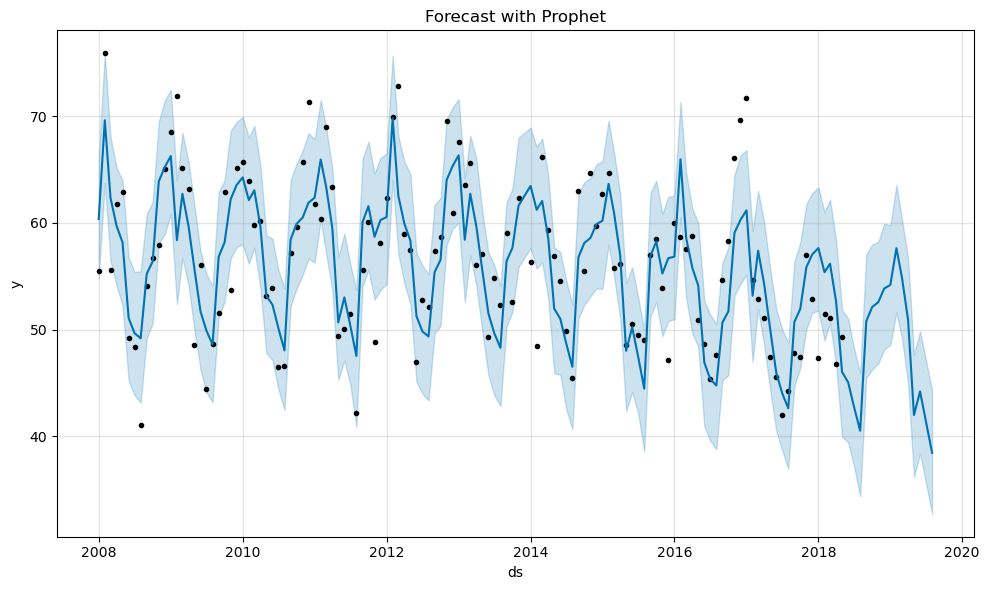

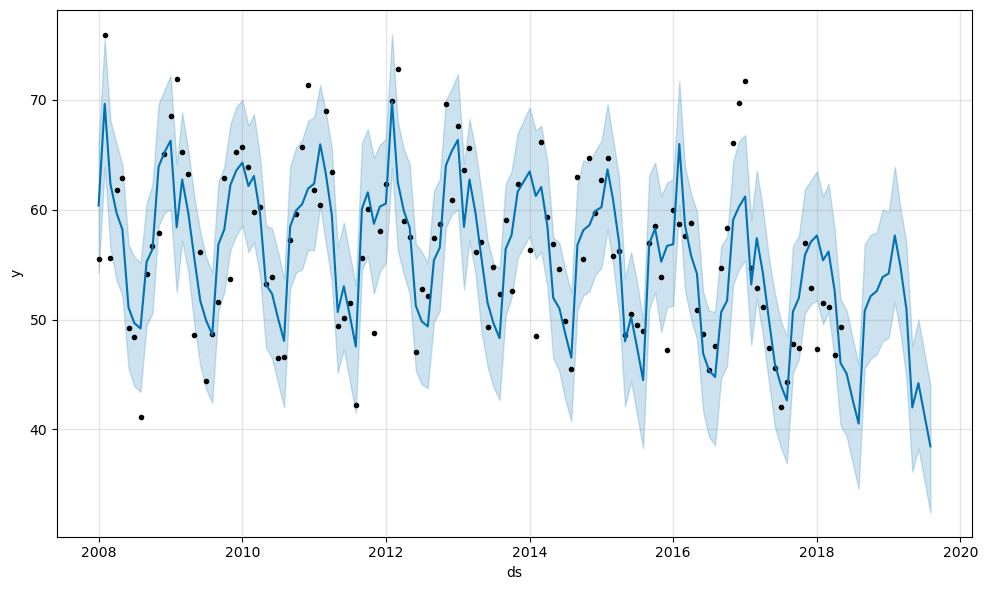

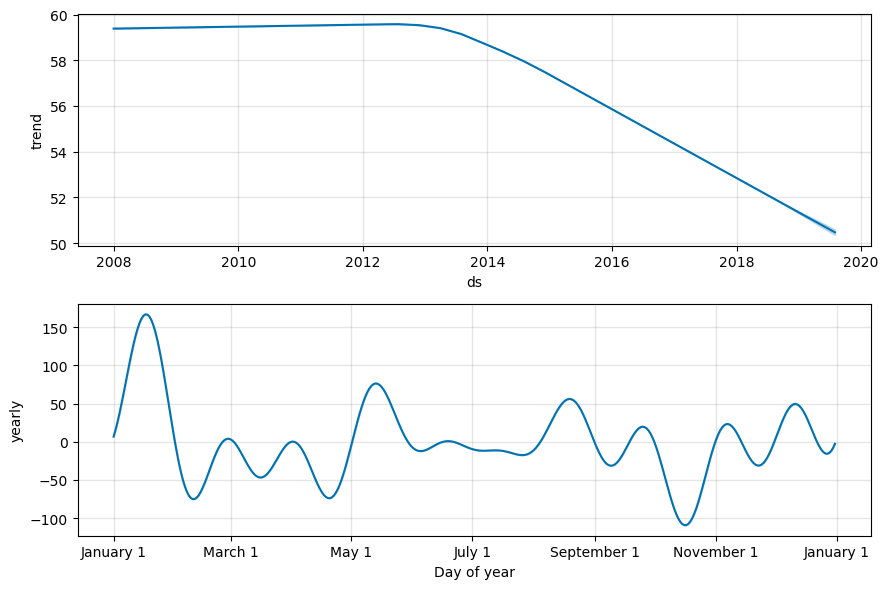

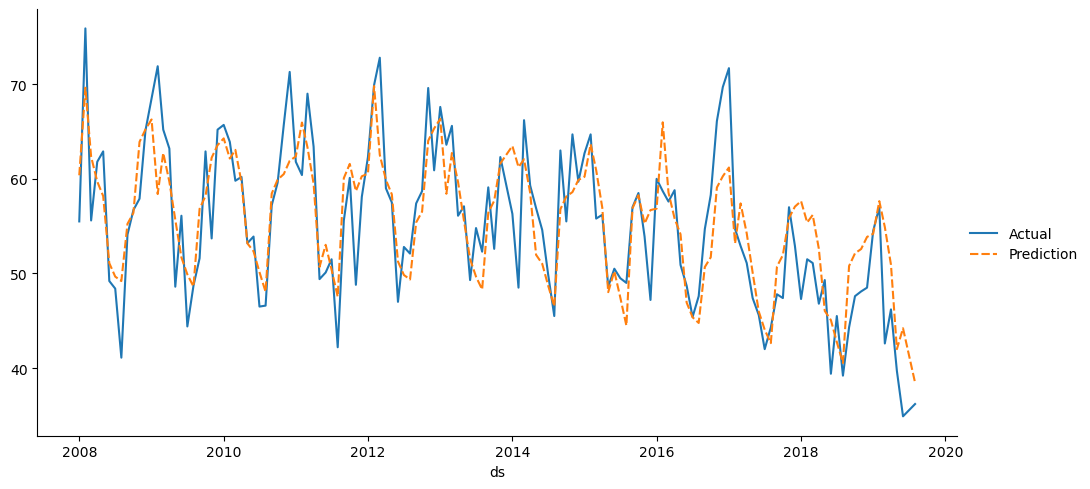

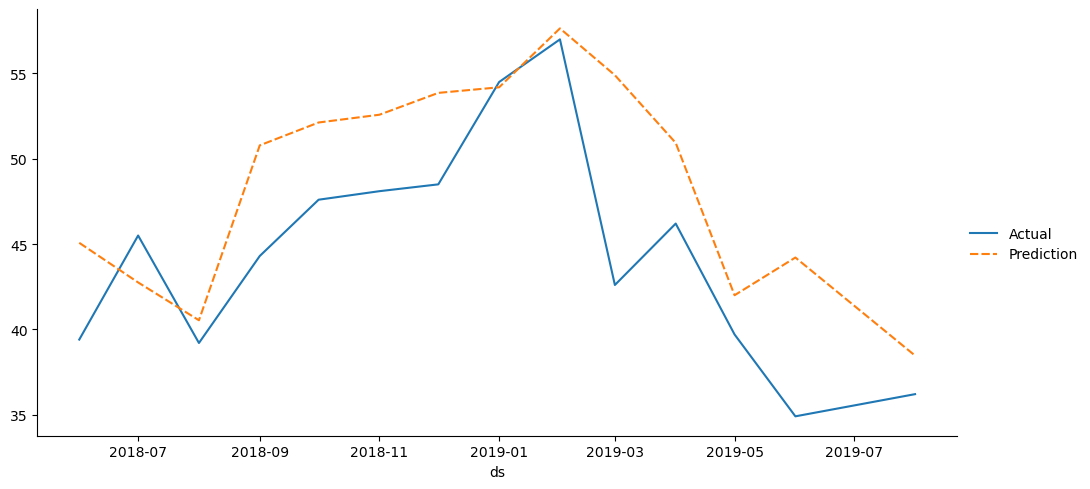

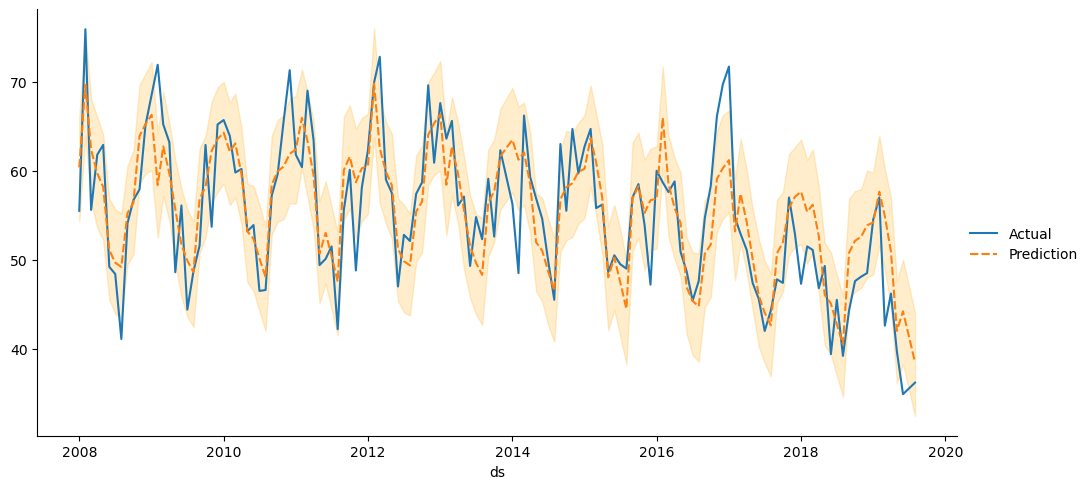

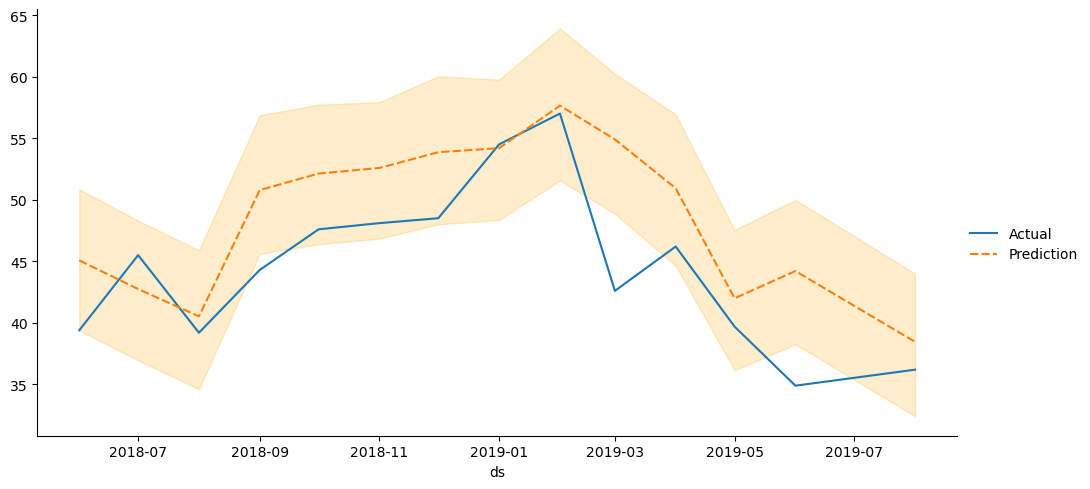

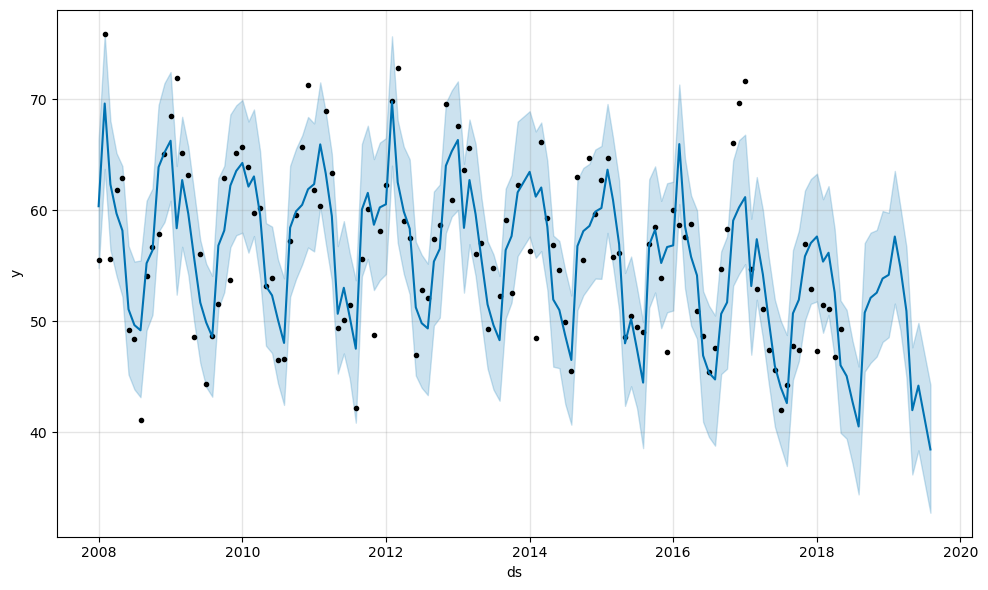

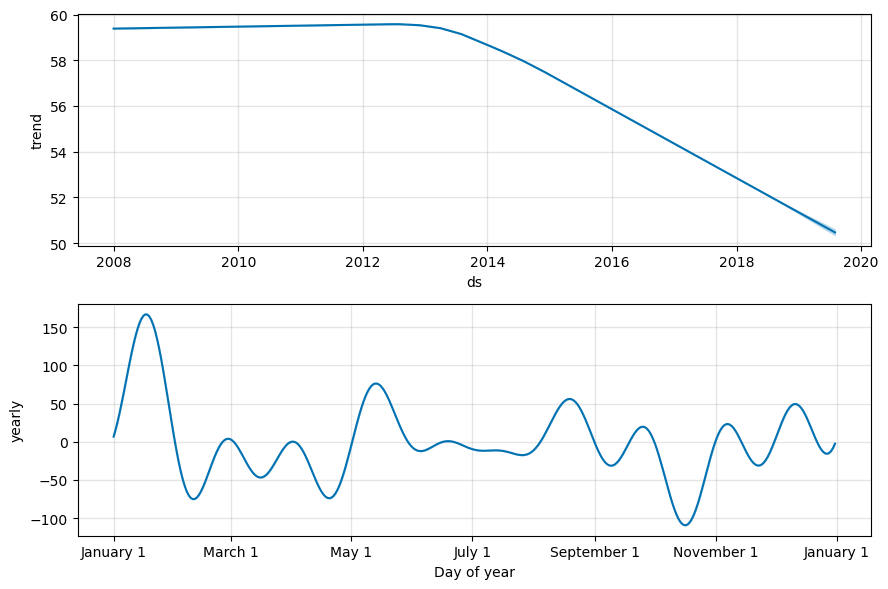

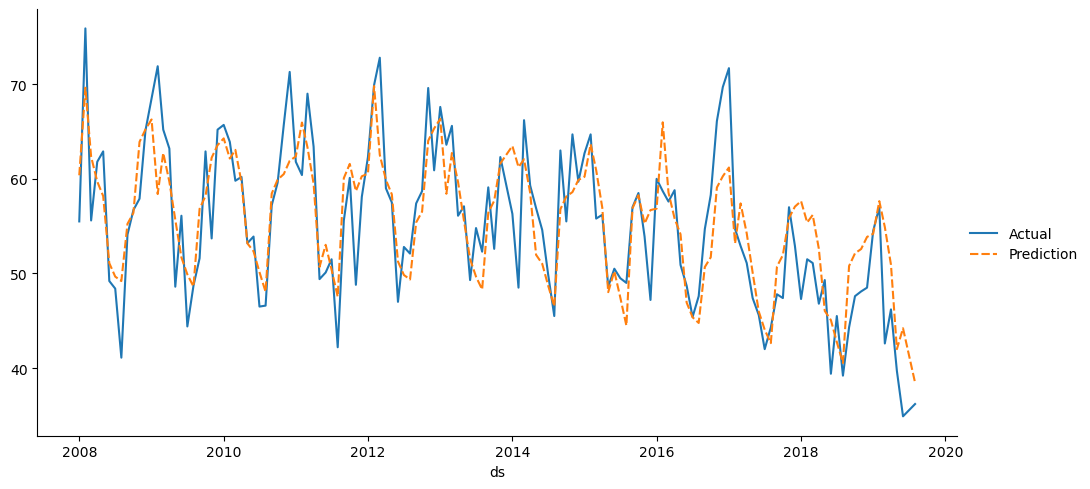

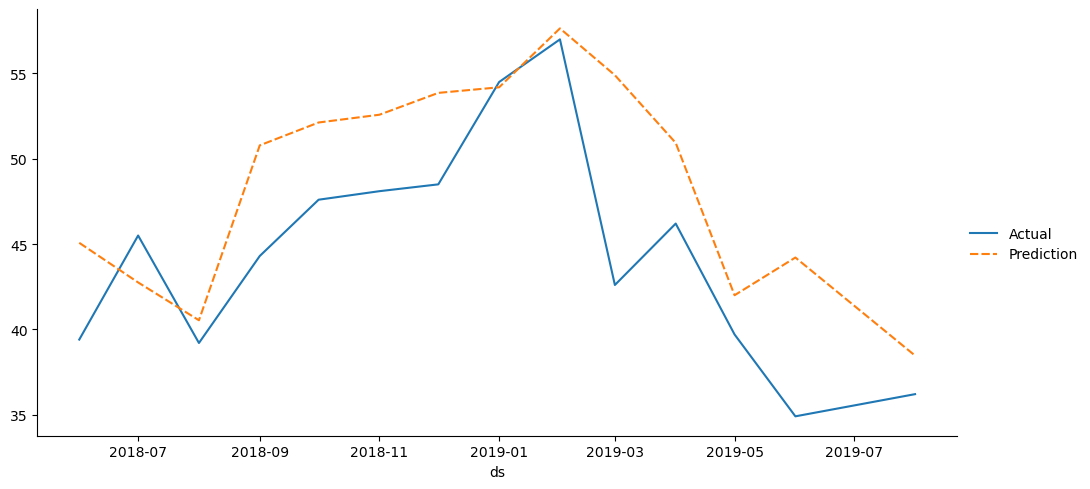

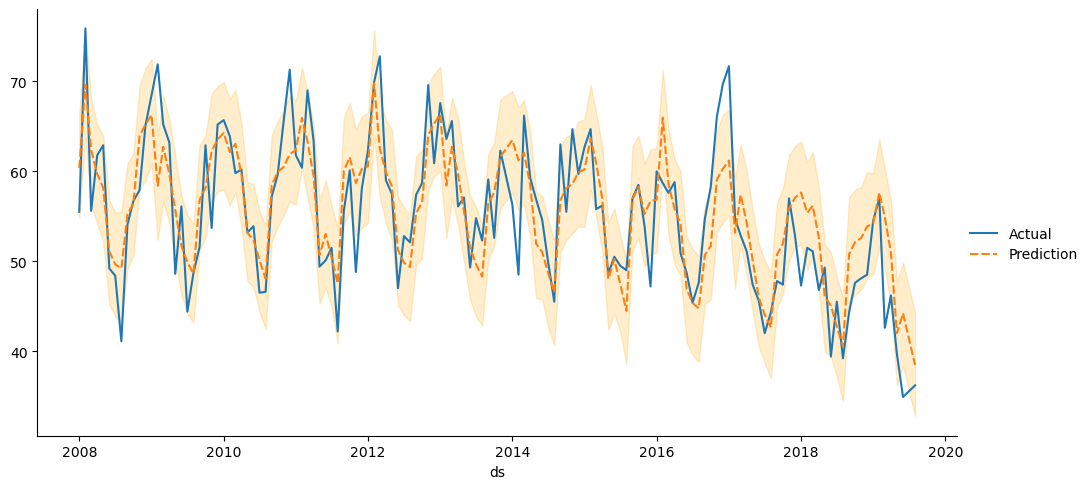

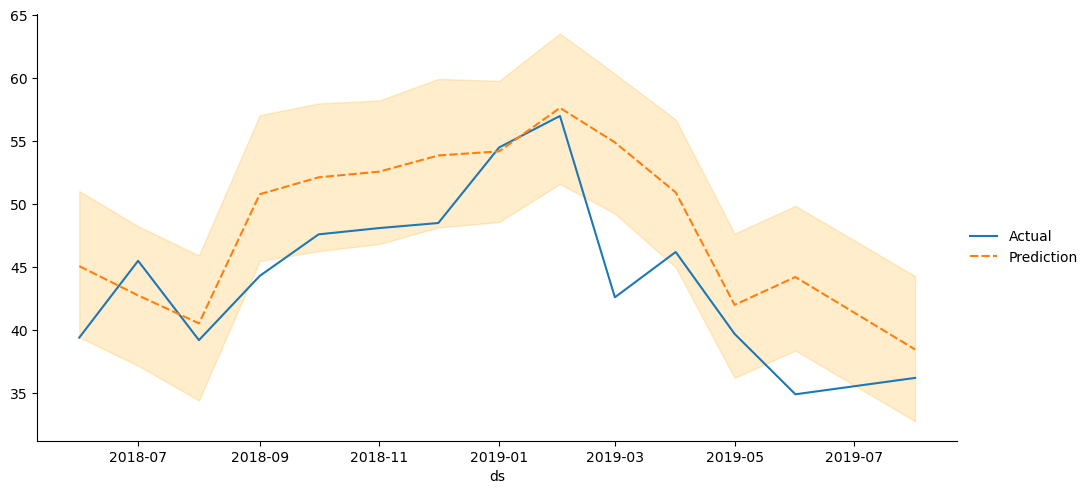

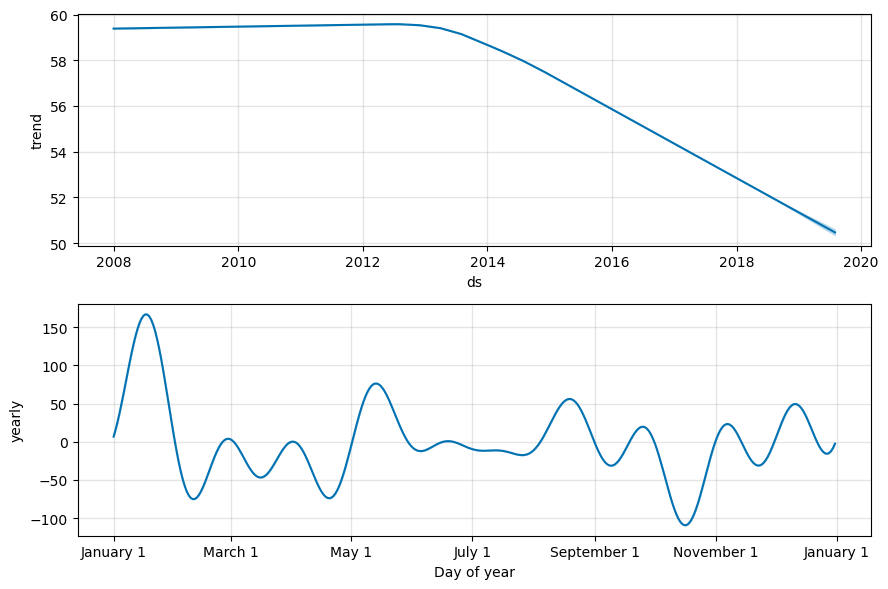

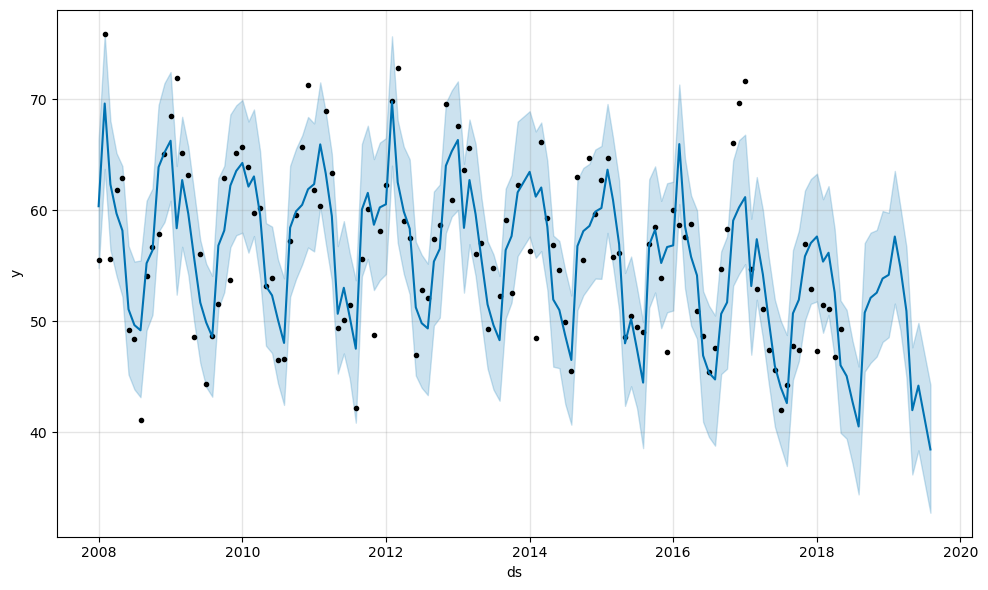

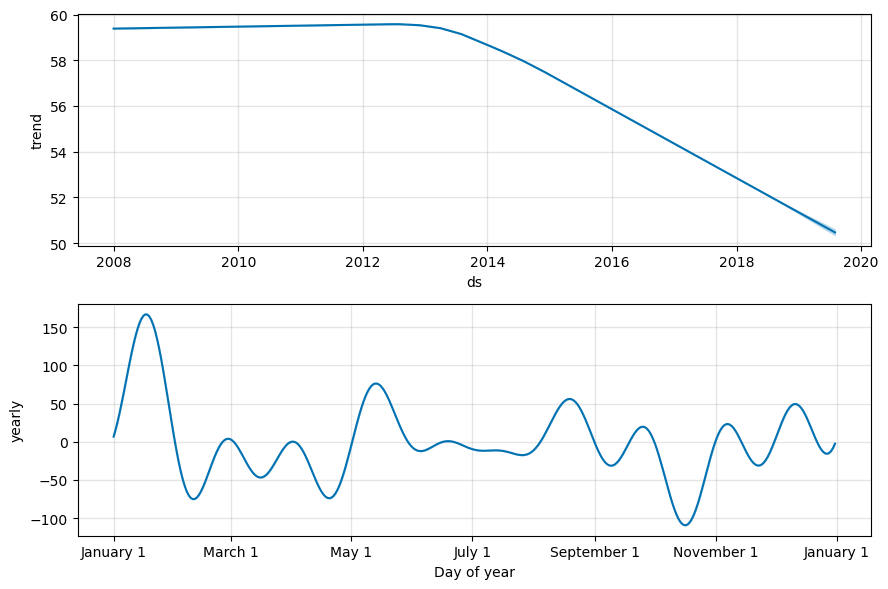

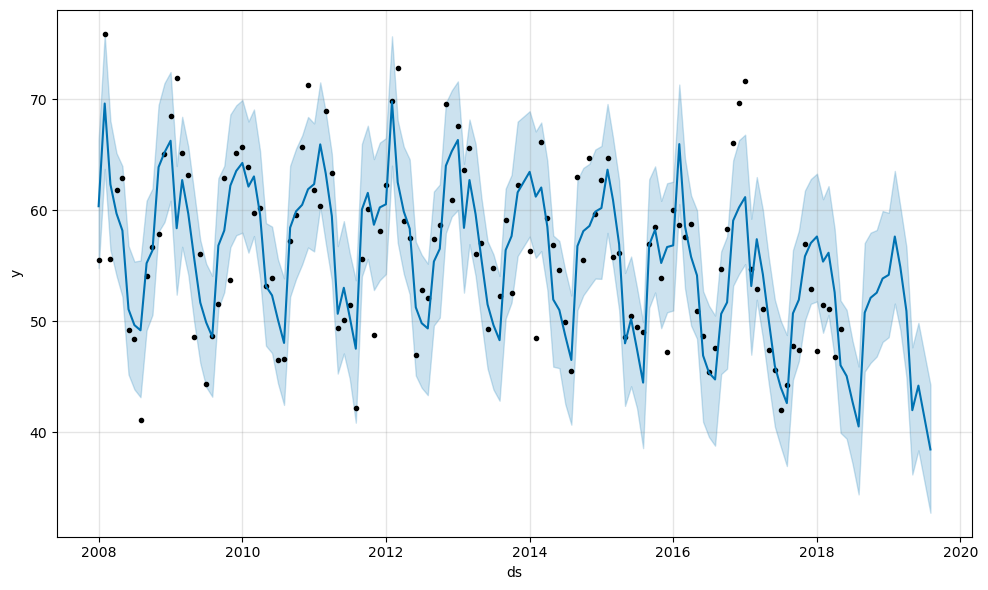

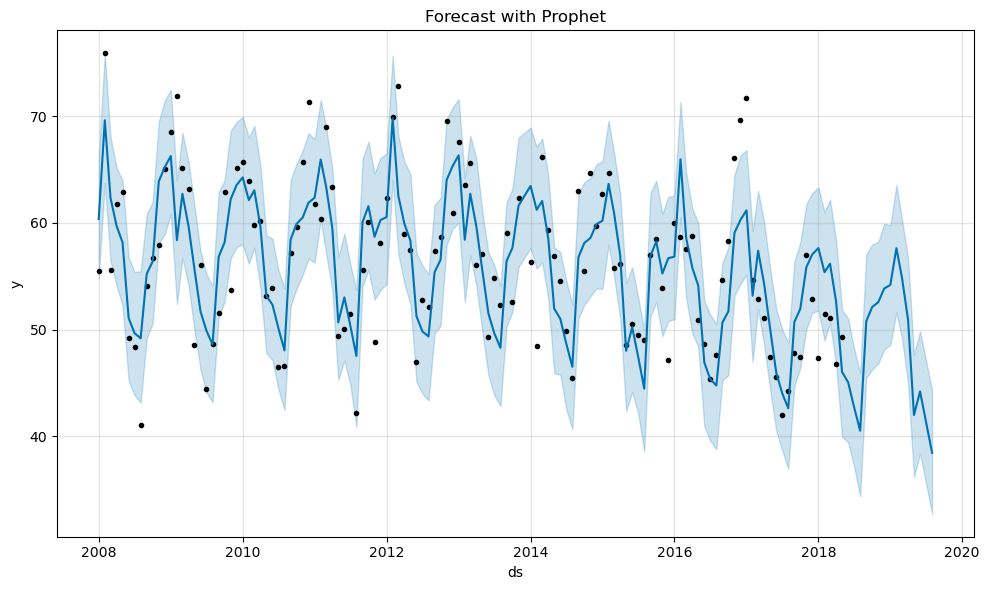

In [37]:
# After your existing code: model = ..., forecast = ...
fig = model.plot(forecast)
plt.title("Forecast with Prophet")
plt.tight_layout()
display(fig)      # forces render in Jupyter
plt.show()        # extra safety

In [36]:
# Plotting forecast with built in plotting function
model.plot(forecast);

In [34]:
# Plotting trend and seasonal components
model.plot_components(forecast);

We'll have to use custom plots to be able to zoom into the prediction region

In [30]:
# Gathering plot info into data frame
plot_df = no2_df.rename(columns={'y': 'Actual'}).set_index('ds')
plot_df['Prediction'] = forecast.set_index('ds')['yhat'] #common index will be aligned

# Plotting
sns.relplot(
    plot_df,
    kind='line',
    aspect=2
)
# Zooming in on prediction region
sns.relplot(
    plot_df.iloc[idx_split:],
    kind='line',
    aspect=2
);

With some matplotlib we can bring the confidence regions back into our custom plots

In [31]:
# Plotting
g_full = sns.relplot(
    plot_df,
    kind='line',
    aspect=2
)
g_zoomed = sns.relplot(
    plot_df.iloc[idx_split:],
    kind='line',
    aspect=2
)

# Getting axes for shading confidence regions
ax_full = g_full.ax 
ax_zoomed = g_zoomed.ax 

# Fill confidence regions
for ax, forecasted in [(ax_full, forecast), (ax_zoomed, forecast.iloc[idx_split:])]:
    ax.fill_between(
        forecasted['ds'],           # Dates of prediction region
        forecasted['yhat_lower'],   # Lower confidence bound
        forecasted['yhat_upper'],   # Upper confidence bound
        color='orange', 
        alpha=0.2,
        label='Confidence Interval'
    );

Looks like we have a few months where the real values are outside the confidence region. Given it is a 95% confidence interval, we should expect this to happen 5% of the time, but the real values are outside of the region more than 5% of the time meaning the model is not just inaccurate, it is overconfident: not accuractely estimating it's own uncertainty.